# Linear Mean-Reversion Strategy for EWA, EWC, and IGE

This part demonstrates a mean-reversion trading strategy applied to a portfolio of EWA, EWC, and IGE ETFs. We will use the Johansen cointegration test to determine the relationships between these ETFs, calculate the mean-reversion parameters, and evaluate the strategy's performance.

*This linear-mean-reverting strategy is obviously not a practical strategy, at least in its simplest version. Despite such impracticalities, the importance of backtesting a mean-reverting price series with this simple linear strategy is that it shows we can extract profits with out any data-snooping bias, as the strategy has no parameters to optimize.


### 1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.regression.linear_model import OLS

### 2. Download Price Series Data
We will use yfinance to download the adjusted closing prices for the ETFs EWA, EWC, and IGE.

In [2]:
# Download price series data
ewa = yf.download("EWA", start="2006-04-26", end="2012-04-09")["Adj Close"].values
ewc = yf.download("EWC", start="2006-04-26", end="2012-04-09")["Adj Close"].values
ige = yf.download("IGE", start="2006-04-26", end="2012-04-09")["Adj Close"].values

# Combine the three price series into a matrix
y3 = np.column_stack((ewa, ewc, ige))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### 3. Perform Johansen Cointegration Test
Apply the Johansen cointegration test to the combined price series.

In [3]:
# Johansen test function
def johansen_test(data, p=0, k=1):
    return coint_johansen(data, det_order=p, k_ar_diff=k)

# Perform Johansen test
results = johansen_test(y3)

# Display Eigenvalues and Eigenvectors
print("Eigenvalues:", results.lr1)
print("Eigenvectors:\n", results.evec)


Eigenvalues: [34.6373274  16.83314347  4.38685581]
Eigenvectors:
 [[ 1.60318083 -0.25799647  0.12242407]
 [-1.49282668 -0.70940909  0.4104957 ]
 [ 0.3484282   0.72618231 -0.15673923]]


### 4. Calculate Portfolio Value and Mean-Reversion Parameters
Form the portfolio using the first eigenvector from the Johansen test and calculate the mean-reversion parameters.

In [4]:
# Form the portfolio using the first eigenvector
eigenvector_1 = results.evec[:, 0]
yport = np.dot(y3, eigenvector_1)

# Calculate lagged yport (shift by 1)
ylag = pd.Series(yport).shift(1)

# Calculate deltaY (difference in yport)
deltaY = pd.Series(yport) - ylag

# Remove NaNs
deltaY = deltaY.dropna()
ylag = ylag.dropna()

# Ensure both deltaY and ylag have the same length
assert len(deltaY) == len(ylag), "deltaY and ylag must be of the same length"

# OLS regression: deltaY ~ ylag + constant
X = np.column_stack([ylag, np.ones(len(ylag))])  # Add constant term
model = OLS(deltaY, X).fit()

# Half-life of mean reversion
halflife = -np.log(2) / model.params.iloc[0]
print("Estimated Half-life of mean reversion:", halflife)


Estimated Half-life of mean reversion: 21.60351250996352


### 5. Apply the Mean-Reversion Strategy
Calculate the number of units to trade, the positions in each ETF, and the daily P&L.

In [5]:
# Placeholder functions for moving average and moving standard deviation
def movingAvg(series, window):
    return series.rolling(window=window).mean()

def movingStd(series, window):
    return series.rolling(window=window).std()

# Set lookback period to the calculated half-life
lookback = round(halflife)

# Calculate the number of units of the unit portfolio to trade
numUnits = -(yport - movingAvg(pd.Series(yport), lookback)) / movingStd(pd.Series(yport), lookback)

# Calculate positions in each ETF
positions = np.dot(np.array(numUnits).reshape(-1, 1), eigenvector_1.reshape(1, -1)) * y3

# Calculate daily P&L of the strategy
def lag(series, periods=1):
    """Function to shift the series by a certain number of periods."""
    return series.shift(periods=periods)

# Calculate P&L and returns
pnl = np.sum(lag(pd.DataFrame(positions), 1) * (pd.DataFrame(y3) - lag(pd.DataFrame(y3), 1)) / lag(pd.DataFrame(y3), 1), axis=1)
ret = pnl / np.sum(np.abs(lag(pd.DataFrame(positions), 1)), axis=1)

# Cumulative returns
cumulative_returns = (1 + ret).cumprod()

# Display cumulative returns
print("Cumulative Returns:\n", cumulative_returns)


Cumulative Returns:
 0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1494    2.003217
1495    2.012679
1496    2.014357
1497    2.018575
1498    2.010897
Length: 1499, dtype: float64


### 6. Evaluate Strategy Performance
Calculate and display the annualized return (APR) and Sharpe ratio.

In [6]:
# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """Calculates the Sharpe Ratio."""
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    return sharpe_ratio

# Calculate APR (Annualized Return)
days_per_year = 252
annualized_return = (np.prod(1 + ret) ** (days_per_year / len(ret)) - 1) * 100

# Calculate Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(ret)

# Display APR and Sharpe Ratio
print(f"Annualized Return (APR): {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Annualized Return (APR): 12.46%
Sharpe Ratio: 0.10


### 7. Plot Cumulative Returns
Visualize the cumulative returns of the mean-reversion strategy.

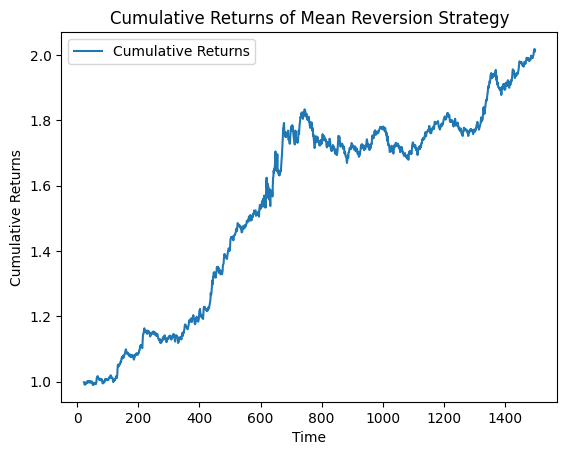

In [7]:
# Plot cumulative returns
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title('Cumulative Returns of Mean Reversion Strategy')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
